In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from astropy.io import fits # used for FITS file management
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground

PAL5_data/PAL5/PAL5_3p6um.fits
FLUXCONV = 0.1257
EXPTIME = 585.054


90


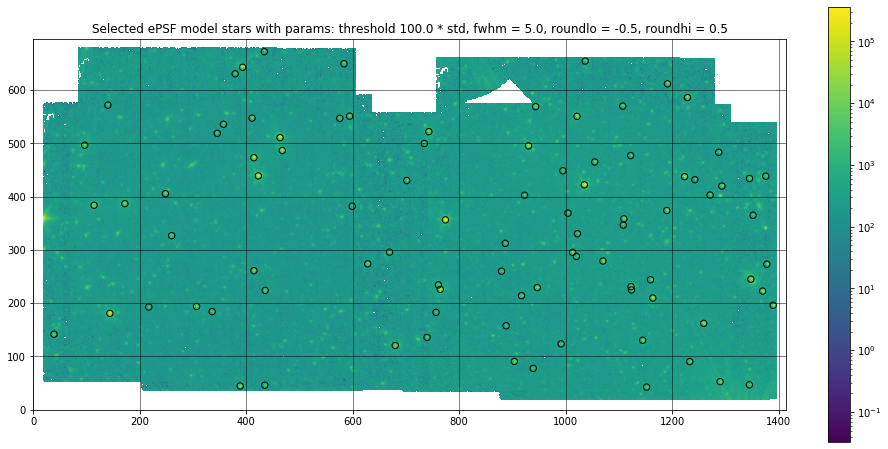

 id      xcenter       ...      aper_bkg       aper_sum_bkgsub  
           pix         ...                                      
--- ------------------ ... ------------------ ------------------
  1 1152.0517082774918 ... 33771.679623118565 121095.16155384525
  2  388.5643966406068 ...  32015.61120598642  322430.4623181619
  3  434.8194022933505 ...    25150.689570927  82217.14853755586
  4 1344.9425064804868 ...  53700.70166004442 124397.40231768812
  5 1290.0140281406764 ...  57062.67251304021   271029.249020998
  6  938.9457034595329 ... 27150.577523127617  88848.09400136855
  7  903.5050731205179 ...  36610.50972161297 223566.70147270372
  8 1232.9300012743536 ...  34884.79168961194 108607.58025913624
  9  679.8036346595079 ...  48593.31703697394  301159.5278271151
 10  991.3280373263775 ... 30017.395484592198  86107.08153782108
...                ... ...                ...                ...
 81   943.554028495274 ...  34022.43313484348 215340.38046260228
 82 1107.2475758751827 ..

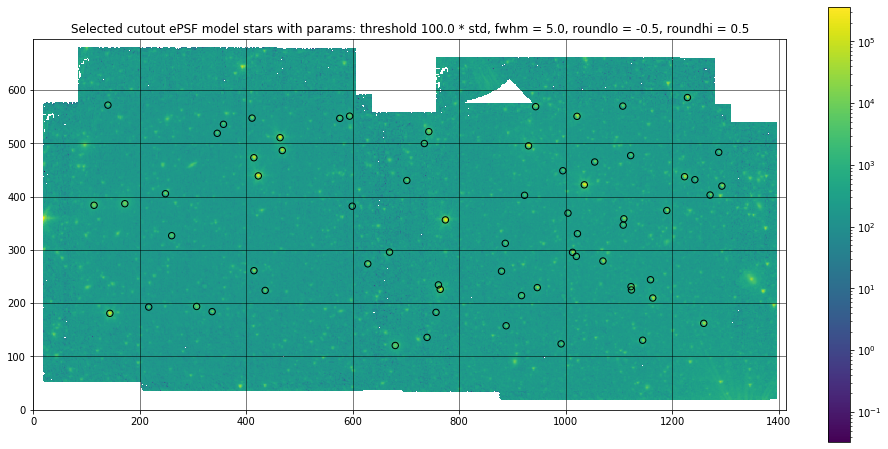

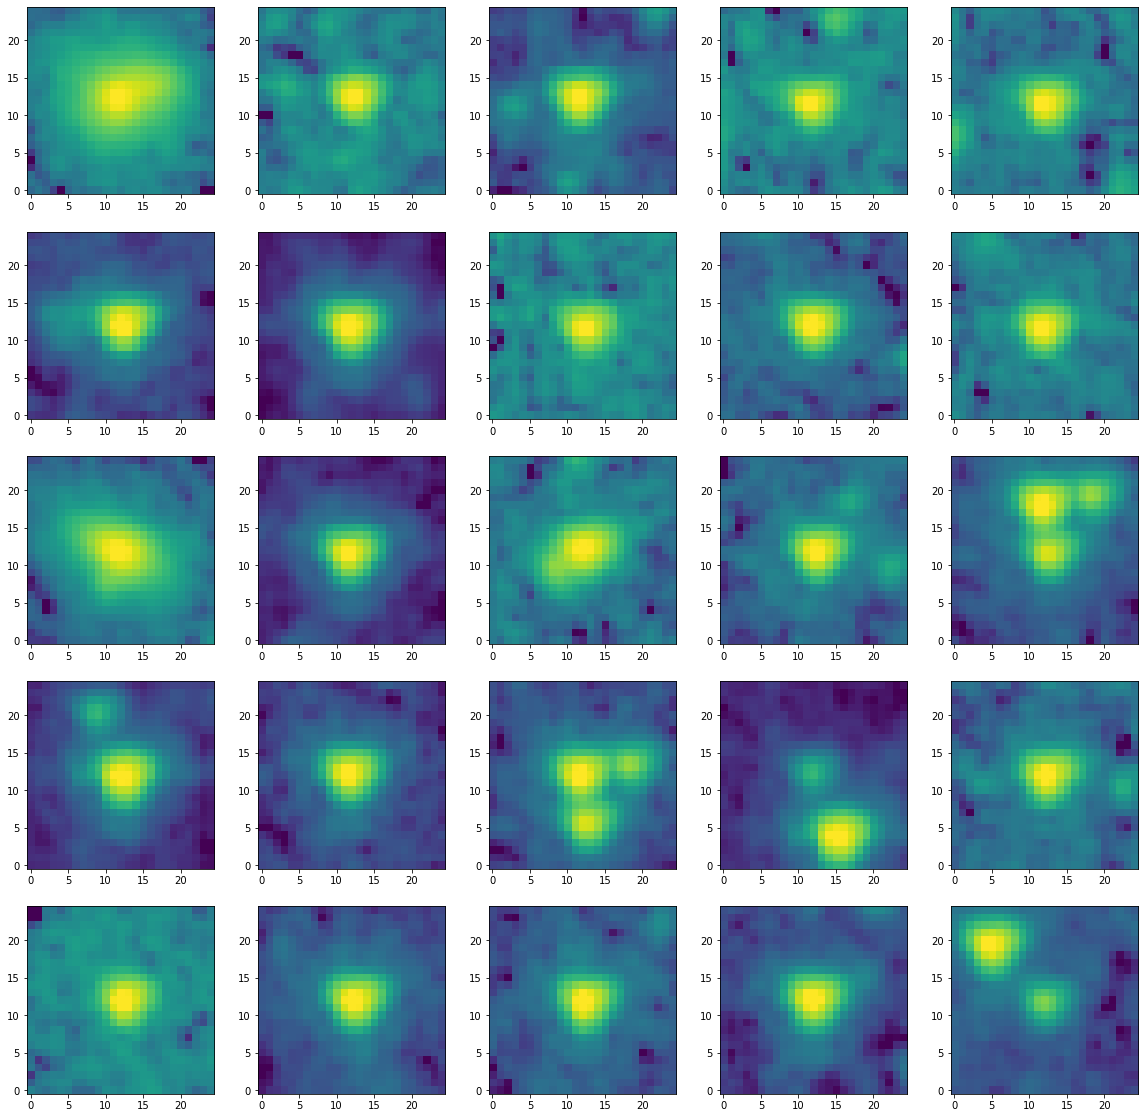

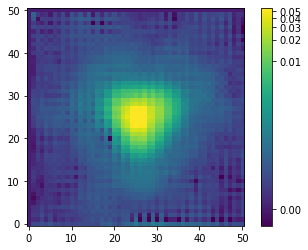

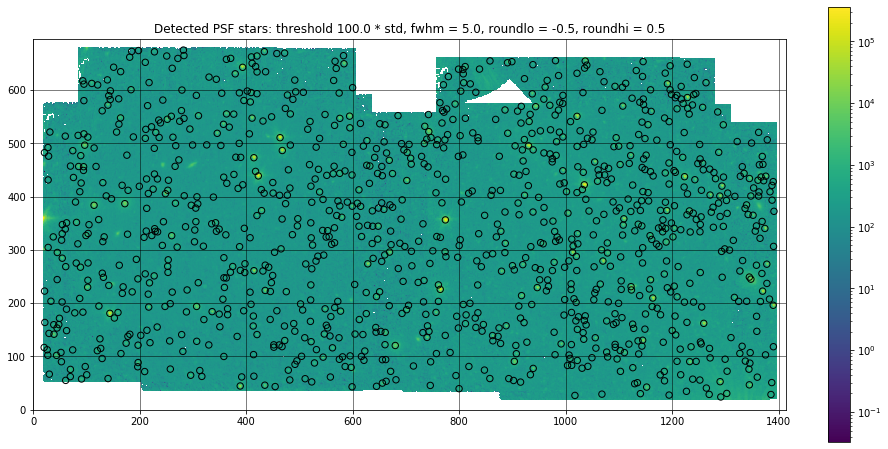

Number of stars detected = 1113


1344


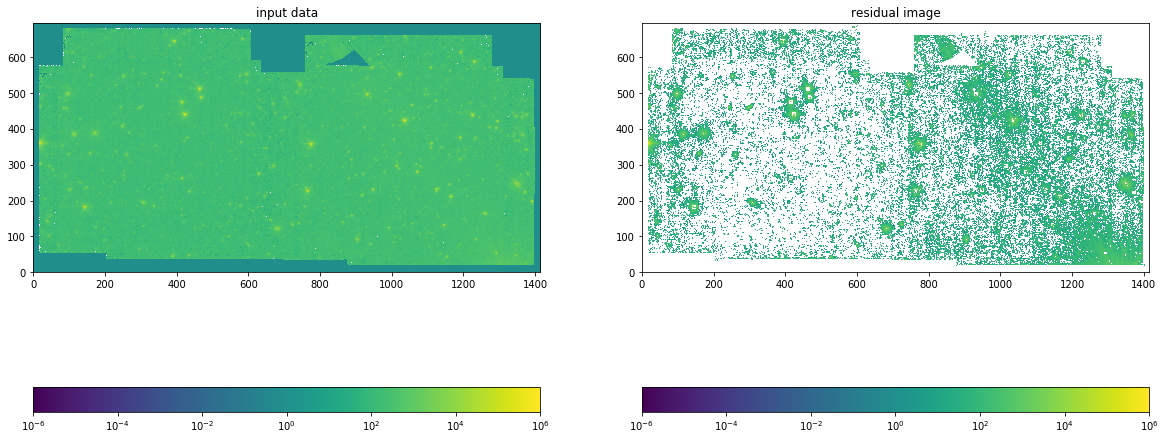

 id    x_0       y_0      flux_0   apparent_mag
--- --------- --------- ---------- ------------
  1 878.98099 20.885002 -11079.825          nan
  2 1002.5942 21.260983   -4362.62          nan
  5 1017.3142 26.634326  7157.1347    18.204922
  3   1306.64 21.371443  58182.039    15.929798
 11 1302.5324 30.413832   86161.17    15.503491
  4 1393.4269 21.721092 -344.81264          nan
  9 1385.5651 28.366621  31371.168    16.600444
 35 1387.0235 50.797877  32694.487    16.555584
  6 1194.2221 27.325663  4086.5772    18.813371
  7 1068.0214 29.086694  2731.2489    19.250867
...       ...       ...        ...          ...
184 953.62819  658.4429 -8751.3407          nan
190 956.91395 670.49476  360785.25    13.948648
185 1155.9979 658.21207 -5534.5785          nan
187 271.46216 659.64182 -541.27819          nan
188 885.46222 659.22822 -11657.183          nan
189 457.36822 668.86272 -5644.0557          nan
191 228.27422 674.83608 -1515.4451          nan
194 247.91147 678.66991 -11759.233      

In [2]:
## DEFINING BASE DATA DIRECTORY ##

base_dir = 'PAL5_data/PAL5/'
channel = '3p6um'

file = base_dir+'PAL5_'+channel+'.fits'
print(file)

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(file) as header_list:
    header = header_list[0].header
    fluxconv = header['FLUXCONV']
    exptime = header['EXPTIME']
    counts = exptime / fluxconv
    image_data = fits.getdata(file, ext = 0)
    data = image_data * counts
    print('FLUXCONV = {}\nEXPTIME = {}'.format(fluxconv, exptime))
#___________________________________#
## BUILDING ePSF MODEL FOR PHOTOMETRY
## SOURCE DETECTION FOR ePSF MODEL ##

# PARAMETERS #
sigma_val = 4.
fwhm = 5.
threshold = 100.
roundlo = -0.5
roundhi = 0.5
sharphi = 0.8

mean, median, std = sigma_clipped_stats(data, sigma = sigma_val)

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = threshold * std, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
epsf_sources = starfind_init(data)
print(len(epsf_sources))

# plot detected stars for ePSF model to verify good stars
positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
apertures = CircularAperture(positions, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Selected ePSF model stars with params: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

## APERTURE PHOTOMETRY ##

positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
circular_apertures = CircularAperture(positions, r = 6.)
annuli_apertures = CircularAnnulus(positions, r_in = 6., r_out = 14.)
apertures = [circular_apertures, annuli_apertures]

# initial aperture photometry table
phot_init = aperture_photometry(data, apertures)

# background subtraction using sigma-clipped median and annuli
annulus_masks = annuli_apertures.to_mask(method = 'center')

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0] # extract 1D array of data values
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d) # utilise sigma clipping on the annulus masks
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
# now append bkg_median, aperture background and aperture sum background values to photometry data
phot_init['annulus_median'] = bkg_median
phot_init['aper_bkg'] = bkg_median * circular_apertures.area
phot_init['aper_sum_bkgsub'] = phot_init['aperture_sum_0'] - phot_init['aper_bkg']
print(phot_init)

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
       (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

# table of star positions
star_tbl = Table()
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
print(len(star_tbl))

# visualise stars to verify
cutout_pos = np.transpose((star_tbl['x'], star_tbl['y']))
cutout_apers = CircularAperture(cutout_pos, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
cutout_apers.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Selected cutout ePSF model stars with params: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

## EXTRACT STARS ##

mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = 5.)
temp_data = data - median_val

nddata = NDData(data = temp_data)
stars = extract_stars(nddata, star_tbl, size = 25)

# visualise 36 extracted stars
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent = 99.)
    ax[i].imshow(stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
plt.show()
plt.close()
    
## BUILD ePSF ##

epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
epsf, fitter = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent = 99.)
plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
plt.colorbar()
plt.show()

## PSF PHOTOMETRY ##

## SOURCE DETECTION ON ORIGINAL IMAGE ##
# PARAMETERS #

sigma_psf = 5.
fwhm = 5.
roundlo = -0.5
roundhi = 0.5

psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_psf * std, roundlo = roundlo, roundhi = roundhi)
psf_sources = psf_daofind(data)

psf_positions = np.transpose((psf_sources['xcentroid'], psf_sources['ycentroid']))
psf_apertures = CircularAperture(psf_positions, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
psf_apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Detected PSF stars: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

print('Number of stars detected = {}'.format(len(psf_sources)))

## GROUP ##

psf_sources['xcentroid'].name = 'x_0'
psf_sources['ycentroid'].name = 'y_0'

daogroup = DAOGroup(crit_separation = sigma_psf * fwhm)
bkg_estimator = MMMBackground()
fitter = LevMarLSQFitter()

data_psf = np.nan_to_num(data, nan = 1**-7)

## PHOTOMETRY ##

PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                    group_maker = daogroup,
                                                    bkg_estimator = bkg_estimator,
                                                    psf_model = epsf,
                                                    fitter = fitter,
                                                    niters = 2,
                                                    aperture_radius = 6.,
                                                    fitshape = (11, 11))

result_phot = PSF_photometry(image = data_psf)
residual_image = PSF_photometry.get_residual_image()
print(len(result_phot))
# visualise data
plt.subplot(1, 2, 1)
plt.imshow(data_psf, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
plt.title('input data')
plt.colorbar(orientation = 'horizontal')

plt.subplot(1, 2, 2)
plt.imshow(residual_image, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
plt.title('residual image')
plt.colorbar(orientation = 'horizontal')
plt.gcf().set_size_inches(20, 14)
plt.show()

## APPARENT MAGNITUDES ##
aper_corr = 1.125      # aperture correction for 337 (6,6,14) apertures in channel 1, given in IRAC handbook §4.10
zeropoint_flux = 280.9 # see Reach et al. 2005
zmag = 18.8            # from IRAC handbook §4.8

phot = result_phot                  # redefine photometry table for ease
phot['bkgsub_flux'] = float('NaN')  # populate new column to convert into flux
phot['apparent_mag'] = float('NaN') # populate a new table (very quirky here, nans?)

for i in range(0, len(phot)):
    phot['bkgsub_flux'][i] = phot['flux_0'][i] * fluxconv / exptime
    for i in range(0, len(phot)):
        if phot['bkgsub_flux'][i] >= 0:
            phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['bkgsub_flux'][i] * aper_corr)

# export into csv file
phot['id', 'x_0', 'y_0', 'apparent_mag'].write(r'C:\Users\lukeb\Documents\MPhys_RRLs\output_files\psfphot02_test.txt', format = 'csv', overwrite = True)
           
# format columns
for col in phot.colnames:
    phot[col].info.format = '%.8g'
print(phot['id', 'x_0', 'y_0', 'flux_0', 'apparent_mag'])